1. Microprice paper : https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2970694

2. Author's Code Repo : https://github.com/sstoikov/microprice/
3. Stoikov's video explanation : https://www.youtube.com/watch?v=0ZHypIAxYNo&t=1220s&ab_channel=SashaStoikov

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/sstoikov/microprice/master/BAC_20110301_20110331.csv

--2022-03-14 14:45:12--  https://raw.githubusercontent.com/sstoikov/microprice/master/BAC_20110301_20110331.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16534767 (16M) [text/plain]
Saving to: ‘BAC_20110301_20110331.csv’

BAC_20110301_201103 100%[===================>]  15.77M  --.-KB/s    in 0.1s    

2022-03-14 14:45:12 (128 MB/s) - ‘BAC_20110301_20110331.csv’ saved [16534767/16534767]



In [ ]:
def get_df(fname):
    df=pd.read_csv(fname)
    df.columns = ['date','time','bid','bs','ask','as']
    df = df.dropna()
    df['date']=df['date'].astype(float)
    df['time']=df['time'].astype(float)
    df['bid']=df['bid'].astype(float)
    df['ask']=df['ask'].astype(float)
    df['bs']=df['bs'].astype(float)
    df['as']=df['as'].astype(float)
    
    return df

In [ ]:
def prep_data_sym(T,n_imb,dt,n_spread):
    spread=T['ask']-T['bid']
    n = np.round(1/min(spread))
    ticksize=np.round(min(spread.loc[spread>0])*n)/n
    
    # Spread and mid prices
    T['spread']=T['ask']-T['bid']
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2

    # Filter out spreads more than 0 and less than n_spread*ticksize
    T = T.loc[(T['spread'] <= n_spread*ticksize) & (T['spread']>0)]
    T['imb']=T['bs']/(T['bs']+T['as'])

    # Discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)
    T['next_mid']=T['mid'].shift(-dt)

    # Step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['time'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)

    # Step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]

    # Symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']
    T3=pd.concat([T,T2])
    T3.index = pd.RangeIndex(len(T3.index)) 
    T3 = T3.dropna()
    return T,T3,ticksize

In [ ]:
def estimate(T, K):
  # Transient - Q
  no_move=T[T['dM']==0]
  no_move_counts = no_move.groupby(['spread', 'imb_bucket','next_spread','next_imb_bucket'])["time"].count().unstack(fill_value=0).astype(float)
  for i in range(n_spread):
      Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
      Q_counts = Qi if i==0  else block_diag(Q_counts,Qi)   
     
  # First Absorbing state - R1
  move = T[(T['dM']!=0)]        
  move_counts = move.groupby(['spread', 'imb_bucket','dM'])["time"].count().unstack(fill_value=0).astype(float)
  R_counts = np.resize(np.array(move_counts),(n_imb*n_spread,len(K)))

  # Get probabilities / matrix states
  T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
  T1 = preprocessing.normalize(T1, norm="l1")

  Q=T1[:,0:(n_imb*n_spread)]
  R1=T1[:,(n_imb*n_spread):]
  
  # 2nd absorbing state - R2
  move_counts_2 = move.groupby(['spread', 'imb_bucket','next_spread', 'next_imb_bucket'])["time"].count().unstack(fill_value=0).astype(float)
  R2_counts=np.resize(np.array(move_counts_2),(n_imb*n_spread,n_imb*n_spread))
  T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)
  T2 = preprocessing.normalize(T2, norm="l1")

  Q2=T2[:,0:(n_imb*n_spread)]
  R2=T2[:,(n_imb*n_spread):]

  # G1, B
  G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
  B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
  return G1,B

In [ ]:
def getG6(G1,B,steps = 6):
  G2 = G1+np.dot(B,G1)
  G_steps = G2
  for i in range(3,steps+1):
    BB = np.dot(B,B)
    for j in range(3,i): #G3 -> G6
      BB = np.dot(BB,B)
    G_steps += np.dot(BB,G1)
  return G_steps

In [ ]:
fname='BAC_20110301_20110331.csv'
n_imb=10
n_spread=2
dt=1

data = get_df(fname)

In [ ]:
T_, T,ts=prep_data_sym(data,n_imb,dt,n_spread)
K = np.array([-ts, -ts*0.5, ts*0.5, ts])
G1, B = estimate(T, K)
 
G6= getG6(G1,B)  

df_g6 = pd.DataFrame(np.reshape(G6,(n_imb, n_spread )))
df_g6.index = np.linspace(0, n_imb-1, num=n_imb).astype(int)
df_g6 = df_g6.rename(columns=dict(zip(list(df_g6.columns), sorted(T['spread'].unique()))))

T = T_

mp_adjustments = []
for spread,imb in zip(T["spread"], T["imb_bucket"]):
  mp_adjustments.append(df_g6.loc[imb, spread])

T['microprice'] = np.array(mp_adjustments) + T["mid"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

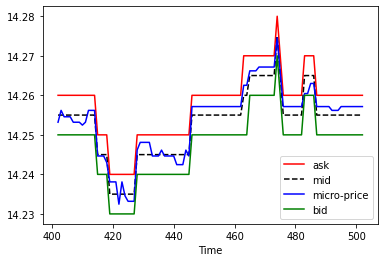

In [ ]:
start = 400
end = start + 100
df_subset = T[start:end]

plt.plot(df_subset["ask"], "r")
plt.plot(df_subset["mid"], "k--")
plt.plot(df_subset["microprice"], "b")
plt.plot(df_subset["bid"], "g")
plt.xlabel("Time")
plt.legend(["ask", "mid", "micro-price", "bid"], loc="lower right")

plt.show()